# Data Preparation for Modeling
Prepare the data for machine learning by splitting into training and testing sets, handling categorical variables, and scaling numerical features. This step ensures our models can be properly trained and evaluated.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the selected features dataset
print("Loading selected features dataset...")
data = pd.read_csv('selected_features.csv')

# Display basic information about the dataset
print(f"Dataset shape: {data.shape}")
print(f"Number of unique classes in success_class: {data['success_class'].nunique()}")
print(f"Class distribution in success_binary:\n{data['success_binary'].value_counts(normalize=True)}")

Loading selected features dataset...
Dataset shape: (196553, 55)
Number of unique classes in success_class: 4
Class distribution in success_binary:
success_binary
0    0.92953
1    0.07047
Name: proportion, dtype: float64


In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print(f"Columns with missing values (top 10):\n{missing_values[missing_values > 0].sort_values(ascending=False)[:10]}")

# Check data types
print("\nData types:")
print(data.dtypes.value_counts())

Columns with missing values (top 10):
lng    112701
lat    112701
dtype: int64

Data types:
int64      37
float64    12
object      5
bool        1
Name: count, dtype: int64


In [4]:
# Identify target variables and features
# We'll use success_binary as our primary target for binary classification
# and success_class for multi-class classification

# Remove all target variables from features
target_columns = ['success_status', 'success_funding', 'success_roi', 
                 'success_age', 'success_score', 'success_binary', 'success_class']

# Select features (all columns except target variables)
X = data.drop(target_columns, axis=1)

# Select target variables
y_binary = data['success_binary']
y_multiclass = data['success_class']

print(f"Features shape: {X.shape}")
print(f"Binary target shape: {y_binary.shape}")
print(f"Multi-class target shape: {y_multiclass.shape}")

Features shape: (196553, 48)
Binary target shape: (196553,)
Multi-class target shape: (196553,)


In [5]:
# Identify categorical and numerical columns
# First, let's separate the columns by data type
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Some columns might be binary (0/1) but stored as numeric
# We'll keep them as numeric for now

print(f"Number of categorical features: {len(categorical_cols)}")
print(f"Number of numerical features: {len(numeric_cols)}")

print("\nCategorical features (first 10):")
print(categorical_cols[:10])

print("\nNumerical features (first 10):")
print(numeric_cols[:10])

Number of categorical features: 5
Number of numerical features: 43

Categorical features (first 10):
['category_code', 'status', 'country_code', 'region_group', 'has_complete_core_info']

Numerical features (first 10):
['funding_efficiency', 'tag_count', 'lng', 'description_length', 'business_keyword_count', 'has_strong_network', 'days_from_creation_to_funding', 'is_in_tech_state', 'days_to_first_funding', 'relationships']


Percentage of missing values in numeric columns (>0%):
lng    57.338733
lat    57.338733
dtype: float64

Columns with >30% missing values: ['lng', 'lat']


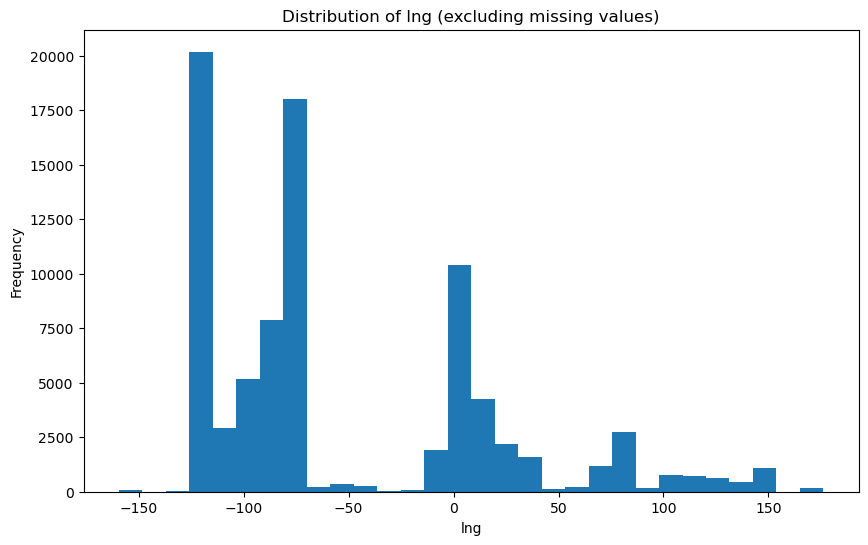

In [6]:
# Handle missing values in numeric columns
# Check the percentage of missing values in each numeric column
numeric_missing = X[numeric_cols].isnull().mean() * 100
print("Percentage of missing values in numeric columns (>0%):")
print(numeric_missing[numeric_missing > 0].sort_values(ascending=False))

# For columns with high missing values, we might need special handling
# Let's look at the distribution of some key numeric columns with missing values
high_missing_cols = numeric_missing[numeric_missing > 30].index.tolist()

if high_missing_cols:
    print(f"\nColumns with >30% missing values: {high_missing_cols}")

    # For demonstration, let's look at the distribution of the first high-missing column
    if len(high_missing_cols) > 0:
        col = high_missing_cols[0]
        plt.figure(figsize=(10, 6))
        plt.hist(X[col].dropna(), bins=30)
        plt.title(f'Distribution of {col} (excluding missing values)')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

In [7]:
# Handle missing values in categorical columns
categorical_missing = X[categorical_cols].isnull().mean() * 100
print("Percentage of missing values in categorical columns (>0%):")
print(categorical_missing[categorical_missing > 0].sort_values(ascending=False))

# For columns with high missing values, we might need special handling
high_missing_cat_cols = categorical_missing[categorical_missing > 30].index.tolist()

if high_missing_cat_cols:
    print(f"\nCategorical columns with >30% missing values: {high_missing_cat_cols}")

    # For demonstration, let's look at the distribution of the first high-missing categorical column
    if len(high_missing_cat_cols) > 0:
        col = high_missing_cat_cols[0]
        plt.figure(figsize=(10, 6))
        value_counts = X[col].value_counts()
        plt.bar(value_counts.index[:10], value_counts.values[:10])
        plt.title(f'Top 10 values in {col} (excluding missing values)')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.show()

Percentage of missing values in categorical columns (>0%):
Series([], dtype: float64)


In [8]:
# Split the data into training and testing sets
# We'll use stratified sampling to maintain the class distribution
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Also create splits for multi-class classification
_, _, y_train_multiclass, y_test_multiclass = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Binary class distribution in training set:\n{y_train_binary.value_counts(normalize=True)}")
print(f"Binary class distribution in testing set:\n{y_test_binary.value_counts(normalize=True)}")

Training set shape: (157242, 48)
Testing set shape: (39311, 48)
Binary class distribution in training set:
success_binary
0    0.929529
1    0.070471
Name: proportion, dtype: float64
Binary class distribution in testing set:
success_binary
0    0.929536
1    0.070464
Name: proportion, dtype: float64


In [9]:
# Create preprocessing pipelines for numerical and categorical features

# For numerical features:
# 1. Impute missing values with median (more robust to outliers than mean)
# 2. Scale the features using StandardScaler

# For categorical features:
# 1. Impute missing values with the most frequent value
# 2. One-hot encode the categorical variables

# Define preprocessing for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # Drop any columns not specified
)

In [10]:
# Fit the preprocessing pipeline on the training data
print("Fitting preprocessing pipeline...")
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after transformation
onehot_features = []
if categorical_cols:
    # Get the one-hot encoded feature names
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    onehot_categories = onehot_encoder.categories_
    for i, col in enumerate(categorical_cols):
        for cat in onehot_categories[i]:
            onehot_features.append(f"{col}_{cat}")

transformed_feature_names = numeric_cols + onehot_features

print(f"Shape of transformed training data: {X_train_transformed.shape}")
print(f"Shape of transformed test data: {X_test_transformed.shape}")
print(f"Number of features after transformation: {X_train_transformed.shape[1]}")

Fitting preprocessing pipeline...
Shape of transformed training data: (157242, 270)
Shape of transformed test data: (39311, 270)
Number of features after transformation: 270


In [11]:
# Save the preprocessing pipeline for future use
print("Saving preprocessing pipeline...")
with open('preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("Preprocessing pipeline saved to 'preprocessing_pipeline.pkl'")

Saving preprocessing pipeline...
Preprocessing pipeline saved to 'preprocessing_pipeline.pkl'


In [12]:
# Convert transformed data to DataFrames for easier handling
# Note: This is optional but makes it easier to work with the data

# Create DataFrames with feature names if possible
if len(transformed_feature_names) == X_train_transformed.shape[1]:
    X_train_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
    X_test_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)
else:
    # If feature names don't match (e.g., due to one-hot encoding), use generic column names
    X_train_df = pd.DataFrame(X_train_transformed, columns=[f'feature_{i}' for i in range(X_train_transformed.shape[1])])
    X_test_df = pd.DataFrame(X_test_transformed, columns=[f'feature_{i}' for i in range(X_test_transformed.shape[1])])

# Add target variables to the DataFrames
X_train_df['success_binary'] = y_train_binary.values
X_train_df['success_class'] = y_train_multiclass.values
X_test_df['success_binary'] = y_test_binary.values
X_test_df['success_class'] = y_test_multiclass.values

In [13]:
# Save the processed datasets
print("Saving processed datasets...")
X_train_df.to_csv('train_data.csv', index=False)
X_test_df.to_csv('test_data.csv', index=False)
print("Processed datasets saved to 'train_data.csv' and 'test_data.csv'")

Saving processed datasets...
Processed datasets saved to 'train_data.csv' and 'test_data.csv'


In [14]:
# Display summary statistics of the processed data
print("\nSummary of processed training data:")
print(f"Shape: {X_train_df.shape}")
print(f"Number of features: {X_train_df.shape[1] - 2}")  # Subtract 2 for the target columns
print(f"Number of samples: {X_train_df.shape[0]}")
print(f"Binary class distribution: {X_train_df['success_binary'].value_counts(normalize=True)}")
print(f"Multi-class distribution: {X_train_df['success_class'].value_counts(normalize=True)}")

print("\nSummary of processed test data:")
print(f"Shape: {X_test_df.shape}")
print(f"Number of features: {X_test_df.shape[1] - 2}")  # Subtract 2 for the target columns
print(f"Number of samples: {X_test_df.shape[0]}")
print(f"Binary class distribution: {X_test_df['success_binary'].value_counts(normalize=True)}")
print(f"Multi-class distribution: {X_test_df['success_class'].value_counts(normalize=True)}")

print("\nData preparation complete!")


Summary of processed training data:
Shape: (157242, 272)
Number of features: 270
Number of samples: 157242
Binary class distribution: success_binary
0    0.929529
1    0.070471
Name: proportion, dtype: float64
Multi-class distribution: success_class
unsuccessful        0.828392
low_success         0.101137
high_success        0.058044
moderate_success    0.012427
Name: proportion, dtype: float64

Summary of processed test data:
Shape: (39311, 272)
Number of features: 270
Number of samples: 39311
Binary class distribution: success_binary
0    0.929536
1    0.070464
Name: proportion, dtype: float64
Multi-class distribution: success_class
unsuccessful        0.828394
low_success         0.101142
high_success        0.058050
moderate_success    0.012414
Name: proportion, dtype: float64

Data preparation complete!
